# Reduced equations (steady-state solution)

Let's find the steady-state solution for the reduced equations:

$$ \frac{\partial \mathcal{W}}{\partial t} = \frac{1}{\Sigma \Omega R^3 } \frac{\partial \mathcal{G}}{\partial R} - \left(\frac{\Omega_z^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{W}.$$
$$ \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{G} - \alpha \Omega \mathcal{G}, $$

I'll follow `reduced-eqs-zhu2019.ipynb` and assume there's only one planet in the system.

## Imports and normalizations

In [2]:
# %pip install fipy

# make 3D plots interactive
use_interactive_plots = False
if use_interactive_plots:
    %matplotlib notebook

import numpy as np
import pandas as pd
import tables
import time
import math
#import scipy.differentiate
import scipy.integrate as integ
import scipy.interpolate as interp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Zhu 2019 uses these parameters: $h\sim H=0.1$, $\alpha=10^{-3},10^{-2},10^{-1}$, planet at $a=1$, $M_p/M_\star=0.003,0.01$.

For the reduced equations to be valid, we require $\alpha \lesssim c_s \sim h$.

In [3]:
cs = 0.02 # 0.02
alpha = 0.01 # 0.1 # 0.019

## Numerical derivatives

In [4]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

## Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$ (so $GM = 1$)
- $\Sigma_0 = 1$
- $c_s = 0.02$ (which implies $H = c_s/\Omega \sim 0.02$)
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

### Density profile

In [5]:
def Sigma(Rs, use_gap):
    '''
    Returns the disk's background surface density profile.
    If use_gap is False, do not include a gap in the profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b, use_gap)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b, use_gap):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    If use_gap is False, return 1 (i.e., no disk gap).
    
    '''

    if use_gap:
        return 1 + (K-1)/2 * \
            (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))
    else:
        return 1

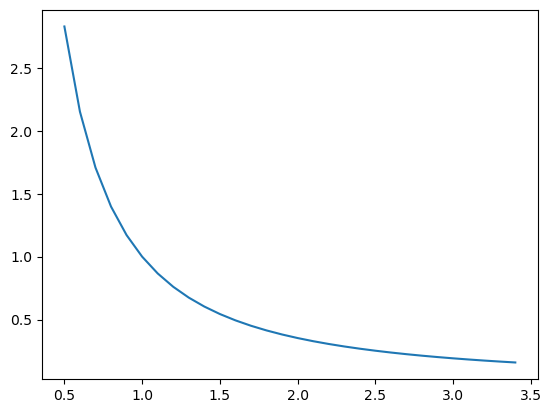

In [6]:
## check shape of disk profile
Rs_warp = np.arange(0.5, 3.5, 0.1)
K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
plt.plot(Rs_warp, Sigma(Rs_warp, False))

### Keplerian orbital frequency

Scale height, which depends on $\Omega$, is defined in the "Planet information" section below.

In [7]:
def OmegaK(Rs):
    '''
    Returns the Keplerian orbital frequency profile.
    Omega_K = sqrt(G*M_star / R^3)

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

## Planet information

If we insert one planet at the disk's inner boundary and one at the disk's outer boundary, can we reproduce Jiaru's results from using fixed (i.e., Dirichlet) boundary conditions?

### Laplace coefficients

In [8]:
# softening term in disk potential; reflects the disk's scale height
soft_term = 0.

def laplace_coeff_integrand(phi, x, j, s):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    phi: the variable that we integrate over
    x: the variable that isn't integrated over
    j, s: See Eq. 6.67 of Murray & Dermott or Eq. 21 in Lubow+Ogilvie.
    
    '''
    
    num = np.cos(j*phi) # numerator
    denom = (1 - 2 * x * np.cos(phi) + x**2 + soft_term**2) ** s
    
    return num / denom

def laplace_coeff(x, j, s):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.

    
    PARAMETERS
    ----------
    x: argument of the Laplace coefficient formula
    
    '''
    
    return 2 / np.pi * integ.quad(laplace_coeff_integrand, 0, np.pi, args=(x, j, s))[0]

Depending on whether the planet is inside ($R \gg a$; large $\alpha$) or outside ($R \ll a$; small $\alpha$) the disk, we can use the quadrupole approximations the Laplace coefficients:

In [9]:
def b0_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^0_{3/2} as a function of 
    alpha = R/a.
    
    If alpha << 1, set `limit` to "small". If alpha >> 1, set 
    `limit` to "large".
    
    '''
    
    if limit=="small":
        return 2 
    elif limit=="large":
        return 2/alpha**3
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

def b1_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^1_{3/2} as a function of 
    alpha = R/a.
    
    '''
    
    if limit=="small":
        return 3*alpha 
    elif limit=="large":
        return 3/alpha**4 
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

But if $\alpha \sim 1$, we should interpolate the Laplace coefficients:

In [10]:
# interpolate Laplace coefficient function (~10x faster)
# large alpha limit
xs_temp = np.linspace(1.001, 20, 10000)
ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
b0_interp_large_alpha = interp.CubicSpline(xs_temp, ys_temp)

ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
b1_interp_large_alpha = interp.CubicSpline(xs_temp, ys_temp)

# small alpha limit
xs_temp = np.linspace(1e-3, .99, 1000)
ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
b0_interp_small_alpha = interp.CubicSpline(xs_temp, ys_temp)

ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
b1_interp_small_alpha = interp.CubicSpline(xs_temp, ys_temp)

And let's check that our approximated functions are accurate:

In [11]:
# correctness checks
print("Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.")
x = 1.03
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="large"))
print(b1_interp_large_alpha(x))

print("\nCorrectness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.")
x = 12
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="large"))
print(b0_interp_large_alpha(x))

print("\nCorrectness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.")
x = .1
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="small"))
print(b1_interp_small_alpha(x))

print("\nCorrectness check: for alpha << 1, b^0_{3/2} ~ 2.")
x = .5
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="small"))
print(b0_interp_small_alpha(x))


Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.
695.889241441088
2.6654611437470663
695.8874279636045

Correctness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.
0.0011756899986620154
0.0011574074074074073
0.0011756899986620146

Correctness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.
0.3057081213944636
0.30000000000000004
0.3057081213944636

Correctness check: for alpha << 1, b^0_{3/2} ~ 2.
3.781491235460853
2
3.7814912354604497


### Orbital, epicyclic, and radial frequencies

(I use Eqs. 25-27 in Lubow+Ogilvie 2000.)

In [12]:
def Omega(Rs, Mp, a):
    '''
    Returns the disk's orbital frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    Omegas_sq = OmegaK(Rs)**2
    alphas = Rs/a
    
    if 1 in alphas:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    for i in range(len(Rs)):
        R = Rs[i]
        alpha = alphas[i]
        planet_term = 0
        
        if alpha < 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_small_alpha(alpha) - \
                            b1_interp_small_alpha(alpha))
        elif alpha > 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_large_alpha(alpha) - \
                            b1_interp_large_alpha(alpha))
        Omegas_sq[i] += planet_term
    
    return np.sqrt(Omegas_sq)

def Kappa(Rs, Mp, a):
    '''
    Returns the disk's epicyclic frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    kappas_sq = OmegaK(Rs)**2
    alphas = Rs/a
    
    if 1 in alphas:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    for i in range(len(Rs)):
        R = Rs[i]
        alpha = alphas[i]
        planet_term = 0
        
        if alpha < 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_small_alpha(alpha) - \
                            2*b1_interp_small_alpha(alpha))
        elif alpha > 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_large_alpha(alpha) - \
                            2*b1_interp_large_alpha(alpha))
        kappas_sq[i] += planet_term

    return np.sqrt(kappas_sq)

def Omega_z(Rs, Mp, a):
    '''
    Returns the disk's vertical frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    Omegazs_sq = OmegaK(Rs)**2
    alphas = Rs/a
    
    if 1 in alphas:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    for i in range(len(Rs)):
        R = Rs[i]
        alpha = alphas[i]
        planet_term = 0
        
        if alpha < 1:
            planet_term = Mp/(2 * a**2 * R) * alpha*b0_interp_small_alpha(alpha)
        elif alpha > 1:
            planet_term = Mp/(2 * a**2 * R) * alpha*b0_interp_large_alpha(alpha)
        Omegazs_sq[i] += planet_term

    return np.sqrt(Omegazs_sq)

### Disk scale height

In [13]:
def scaleHeight(Rs):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega_K.

    '''
    return cs / OmegaK(Rs)

In [14]:
# # spatial and time domains
# Rmin = 0.5
# Rmax = 3.5 
# Rmid = 1.5 # arbitrary point in middle of disk gap
    
# DeltaR = 0.1 # 0.03
# num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# Rs_warp = np.linspace(Rmin, Rmax, num_Rs)

# cses = scaleHeight(Rs_warp)
# plt.plot(Rs_warp, 10*cses)

# print("Courant condition: dt < ", DeltaR / max(cses))

### use scipy's boundary-value problem solver

In [47]:
from scipy.integrate import solve_bvp

In [57]:

dfdR_interp = interp.CubicSpline(Rs_temp, derivative(fs, Rs_temp))

/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])


/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])


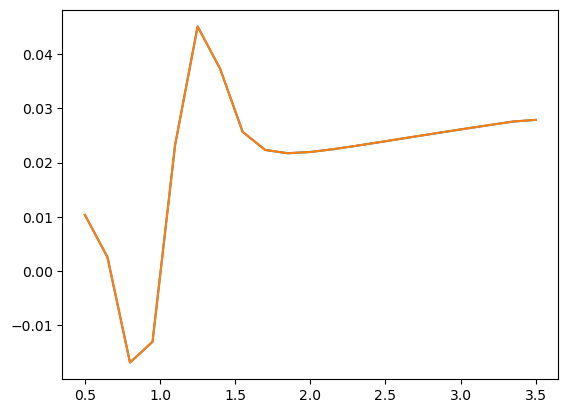

In [61]:
plt.plot(Rs_temp, dfdR_interp(Rs_temp))
plt.plot(Rs_temp, derivative(fs, Rs_temp))


In [98]:
Kappa(Rs_temp,Mp,a)

array([2.82669228, 1.90416114, 1.3845002 , 0.85854096, 0.82410534,
       0.71069899, 0.60257391, 0.51804016, 0.45131027, 0.39768836,
       0.35387171, 0.31753494, 0.28701031, 0.26107716, 0.23882478,
       0.2195618 , 0.20275506, 0.18798763, 0.17492926, 0.16331541,
       0.15293192])

In [113]:
def fun(R, y):

    tilt, dtilt_dR = y

    coeffs1 = alpha + (1j/2)*(Kappa(R,Mp,a)**2 - Omega(R,Mp,a)**2)/(Omega(R,Mp,a)**2)
    f = Sigma(R,False) * scaleHeight(R)**2 * Omega(R,Mp,a)**2 * R**3 / 4 / coeffs1
    
    eq2 = -(1/f)*dfdR_interp(R)*dtilt_dR + (Sigma(R,False) * Omega(R,Mp,a) * R**3)/f \
            * (Omega_z(R,Mp,a)**2 - Omega(R,Mp,a)**2)/Omega(R,Mp,a) * (1j/2) * tilt
    
    return np.vstack((dtilt_dR, eq2))


y_a = np.zeros((2, Rs_temp.size))
y_a[0] = 0.1
y_a[1] = 0.01
# y_b = np.zeros((2, x.size))

# y_b[0] = 3

def bc(ya, yb):
    '''
    ya[0] is y(a), ya[1] is ya'[1]
    
    '''
    return np.array([ya[0], yb[0]-.1])

In [114]:
res_a = solve_bvp(fun, bc, Rs_temp, y_a)
#res_b = solve_bvp(fun, bc, x, y_b)

ValueError: Can't have `a` in the list of Rs; otherwise, we have R/a = 1

In [115]:
res_a.sol(Rs_temp)

array([[ 0.03      ,  0.03005248,  0.0298688 ,  0.0301312 ,  0.0298688 ,
         0.0301312 ,  0.02994752,  0.03      ,  0.03005248,  0.0298688 ,
         0.0301312 ,  0.0298688 ,  0.0301312 ,  0.02994752,  0.03      ],
       [ 0.01      ,  0.00898659, -0.16644422,  0.0239348 ,  0.01029814,
         0.00982604,  0.01002396,  0.01      ,  0.00995497,  0.01007968,
         0.0099212 ,  0.01006548,  0.00993478,  0.01002019,  0.01      ]])

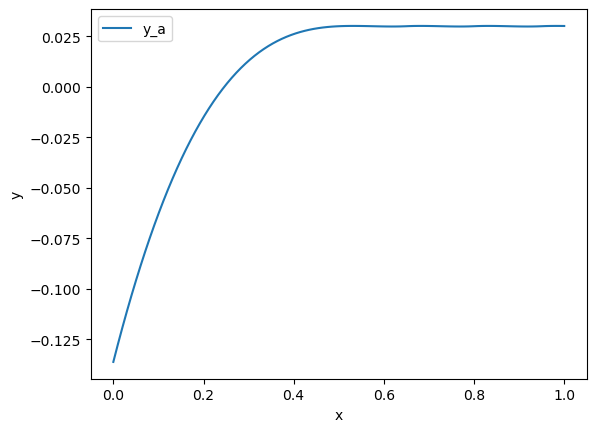

In [112]:
x_plot = np.linspace(0, 1, 100)

y_plot_a = res_a.sol(x_plot)[0]

#y_plot_b = res_b.sol(x_plot)[0]

import matplotlib.pyplot as plt

plt.plot(x_plot, y_plot_a, label='y_a')

#plt.plot(x_plot, y_plot_b, label='y_b')

plt.legend()

plt.xlabel("x")

plt.ylabel("y")

plt.show()

In [103]:
Rs_temp = np.linspace(0.5, 3.5, 15)

Mp, a = 0.003, 1

Sigmas = Sigma(Rs_temp, use_gap=False) # length N+2
Hs = scaleHeight(Rs_temp)
Kappas = Kappa(Rs_temp, Mp, a)
Omegas = Omega(Rs_temp, Mp, a)
Omega_zs = Omega_z(Rs_temp, Mp, a)

coeffs1 = alpha + (1j/2)*(Kappas**2 - Omegas**2)/(Omegas**2)
fs = Sigmas * Hs**2 * Omegas**2 * Rs_temp**3 / 4 / coeffs1



In [32]:
def ode(y, R):
    '''
    '''

    tilt, dtilt_dR = y

    eq2 = -(1/fs)*derivative(fs,Rs_temp)*dtilt_dR + (Sigmas * Omegas * Rs_temp**3)/fs \
            * (Omega_zs**2 - Omegas**2)/Omegas * (1j/2) * tilt
    dydR = [dtilt_dR, eq2]
    return dydR

y0 = [0, 0]
sol = odeint(ode, y0, Rs_temp)

/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### plot $\frac{\kappa^2-\Omega^2}{\Omega^2}$ and other values vs. $R$

/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/3956506390.py:69: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kappas_sq)


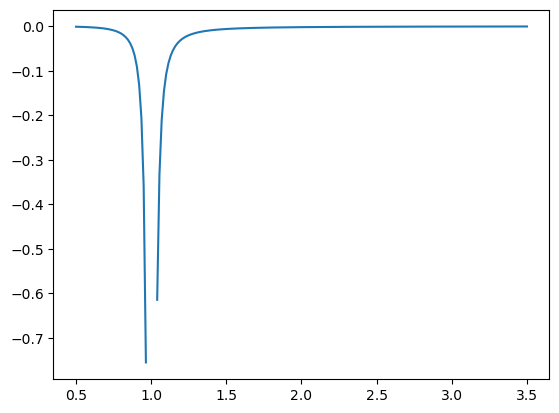

In [15]:
# spatial and time domains
Rmin = 0.5
Rmax = 3.5 
Rmid = 1.5 # arbitrary point in middle of disk gap
    
DeltaR = 0.015 # 0.03
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

Rs_temp = np.linspace(Rmin, Rmax, num_Rs)

Mp, a = 0.003, 1

Kappas = Kappa(Rs_temp, Mp, a)
Omegas = Omega(Rs_temp, Mp, a)

ys = (Kappas**2 - Omegas**2) / (Omegas**2)
plt.plot(Rs_temp, ys)

## b^1_(3/2) looks something like (x-1)^(-2) near x=1
# Rs_temp2 = np.linspace(1.01,3, 100)
# ys = b1_interp_large_alpha(Rs_temp2)
# plt.plot(Rs_temp2, ys)
# Rs_temp1 = np.linspace(.05,.99, 100)
# ys = b1_interp_small_alpha(Rs_temp1)
# plt.plot(Rs_temp1, ys)

plt.show()

In steady-state, we have:
$$ \frac{\partial G}{\partial R} = \frac{\partial}{\partial R} \left[\left[\left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i}2  + \alpha \right]^{-1} \frac{\Sigma H^2 \Omega^2 R^3}4 \right] \cdot \frac{\partial W}{\partial R} + \left[\left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i}2  + \alpha \right]^{-1} \frac{\Sigma H^2 \Omega^2 R^3}4 \frac{\partial^2W}{\partial R^2}. $$

Is either term dominant over the other? Assuming dW/dR and d^2W/dR^2 are of the same magnitude, no (see below graph).

/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/391669520.py:8: RuntimeWarning: invalid value encountered in divide
  coeffs = slosh_coeffs / (ys*1j/2 + alpha)
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
/var/folders/5n/0c1hg8pn7lz4zsrbybrzwr5r0000gn/T/ipykernel_23564/4257268547.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])


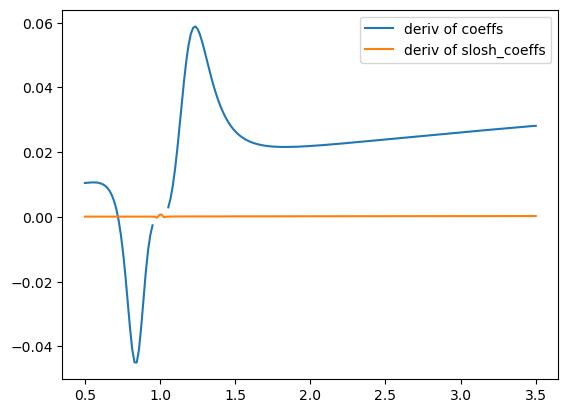

In [17]:
Sigmas = Sigma(Rs_temp, use_gap=False) # length N+2
Hs = scaleHeight(Rs_temp)
Omegas = Omega(Rs_temp, Mp, a)

# sloshing term
slosh_coeffs = Sigmas * (Hs**2) * (Omegas**2) * (Rs_temp**3) / 4 

coeffs = slosh_coeffs / (ys*1j/2 + alpha)

derivs = derivative(coeffs,Rs_temp)
# plt.plot(Rs_temp, coeffs, label="coeffs")
plt.plot(Rs_temp, derivs, label="deriv of coeffs")
#plt.plot(Rs_temp, derivative(1/(ys*1j/2 + alpha),Rs_temp), label="deriv of kappa term")
plt.plot(Rs_temp, derivative(slosh_coeffs,Rs_temp), label="deriv of slosh_coeffs")
plt.legend()
plt.show()

Slosh_coeffs is roughly proportional to $R^{3/2}$:

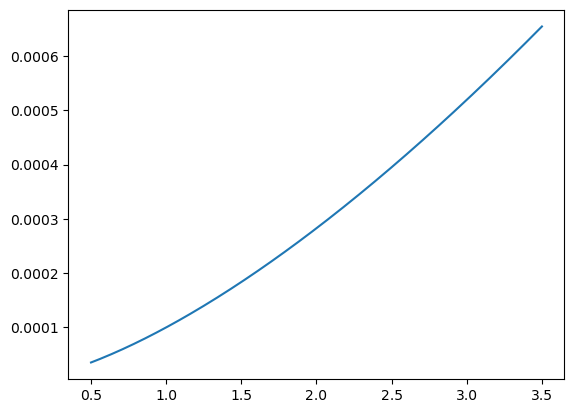

In [20]:
#plt.plot(Rs_temp, derivative(slosh_coeffs,Rs_temp))
plt.plot(Rs_temp, (Rs_temp/.5)**(3/2) * slosh_coeffs[0])